# COMP5318 - Machine Learning and Data Mining: Assignment 2, Best Classifier CNN
<div style="text-align: right"> Group 86 </div>
<div style="text-align: right"> tlin4302 | 470322974 | Jenny Tsai-chen Lin </div>
<div style="text-align: right"> jsun4242 | 500409987 | Jiawei Sun </div>
<div style="text-align: right"> jyan2937 | 480546614 | Jinxuan Yang </div>

### Hardware and software specifcations
hardware:
    1. CPU: Intel i7-8700K @ 3.70GHz
    2. RAM: 64G DDR4 3000MHz
    3. Graphics: NVidia GeForce GTX 1080Ti
    4. Chipset: Z370

### Software specifications

In [1]:
import os, platform
print('OS name:', os.name, ', system:', platform.system(), ', release:', platform.release())
import sys
print("Anaconda version:")
#!conda list anaconda
print("Python version: ", sys.version)
print("Python version info: ", sys.version_info)
import PIL
from PIL import Image
print("PIL version: ", PIL.__version__)
import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib version: ", matplotlib.__version__)
#import tensorflow as tf
#print("Keras version:", tf.keras.__version__)
import cv2
print("OpenCV version: ", cv2.__version__)
import numpy as np
print("nump version: ", np.__version__)

OS name: nt , system: Windows , release: 10
Anaconda version:
Python version:  3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Python version info:  sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)
PIL version:  7.2.0
Matplotlib version:  3.2.2
OpenCV version:  4.4.0
nump version:  1.18.5


## CODE RUNNING INSTRUCTIONS:
    Instruction:
    Simply change the switches in below blocks and run all.
    
    Dataset directory:
    Same directory as the jupyter notebook, in the format of :
    ---[current dir]
      |----[This file]
      |----[dataset]
          |----test
          |----train
          
          
    The default parameters will used the saved model to run simple tests,
    and load confusion matrices, accuracies, etc. from disk and plot them
    for display purpose.

## Section 0. Switches

#### Load saved model or run training?

In [2]:
load_saved_model = True

#### Run 10-fold cross validation? (Slow if turned on)

In [3]:
# Caution: Slow if turned on.
test_CNN_ten_fold = False

## Section 1. Library and general functions 

In [4]:
#  Go to anaconda prompt to install package imblearn
# anaconda: conda install -c glemaitre imbalanced-learn
#pip install kmeans-smote

from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2

import time

### global variables

In [5]:
# choose one of below two line depend file location******

g_dataset_dir = "./dataset/"   
#g_dataset_dir = "../dataset/" 


a_random_file = "./dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg"  
#a_random_file = "../dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg" 

saved_model_path = "./saved_model/"
abc_model_file = saved_model_path + "abc_dump.pkl"
svc_model_file = saved_model_path + "svc_dump.pkl"
cnn_model_file = saved_model_path + "cnn_weights"

ten_fold_result_path = "./ten_fold_results/"


# define global variable 

g_train_dir = g_dataset_dir + "/train/"
g_test_dir = g_dataset_dir + "/test/"

g_image_size = 400

g_grid_row = 8
g_grid_col = 8

g_grid_num = g_grid_row * g_grid_col
g_grid_size = int(g_image_size / g_grid_row)


#Processing 1 - scale down 
g_down_sampled_size = 200
g_down_sampled_grid_size = int(g_grid_size / (g_image_size / g_down_sampled_size))

# global instance of mapping of char vs chess pieces
# reference: Forsyth–Edwards Notation, https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation
# 
# pawn = "P", knight = "N", bishop = "B", rook = "R", queen = "Q" and king = "K"
# White pieces are designated using upper-case letters ("PNBRQK") while black pieces use lowercase ("pnbrqk")
# we use 0 to note an empty grid.
# 13 items in total.

g_piece_mapping = {
    "P" : "pawn",
    "N" : "knight",
    "B" : "bishop",
    "R" : "rook",
    "Q" : "queen",
    "K" : "king",

    "p" : "pawn",
    "n" : "knight",
    "b" : "bishop",
    "r" : "rook",
    "q" : "queen",
    "k" : "king",

    "0" : "empty_grid"
}

g_num_labels = len(g_piece_mapping)

g_labels = ["P",
"N",
"B",
"R",
"Q",
"K",
"p",
"n",
"b",
"r",
"q",
"k",
"0"]


### Helper codes for label & board

In [6]:
#DataHelper.py

import os

import cv2
from skimage import io
import numpy as np

import glob
import h5py

# get clean name by a path, where in our case this gets the FEN conviniently
def GetCleanNameByPath(file_name):
    return os.path.splitext(os.path.basename(file_name))[0]

# get full paths to the files in a directory.
def GetFileNamesInDir(path_name, extension="*", num_return = 0):
    if num_return == 0:
        return glob.glob(path_name + "/*." + extension)
    else:
        return glob.glob(path_name + "/*." + extension)[:num_return]

# get name list
def GetCleanNamesInDir(path_name, extension = "*", num_return = 0):
    names = GetFileNamesInDir(path_name, extension)
    offset = len(extension) + 1
    clean_names = [os.path.basename(x)[:-offset] for x in names]
    if num_return == 0:
        return clean_names
    else:
        return clean_names[:num_return]

# read dataset
def ReadImages(file_names, path = "", format = cv2.IMREAD_COLOR):
    if path == "":
        return [cv2.imread(f, format) for f in file_names]
    else:
        return [cv2.imread(path + "/" + f, format) for f in file_names]

# read image by name
def ReadImage(file_name, gray = False):
    return io.imread(file_name, as_gray = gray)


# h5py functions
    
# read h5py file
# we assume the labels and 
def ReadH5pyFile(file_name, data_name):
    h5_buffer = h5py.File(file_name)
    return h5_buffer[data_name].copy()

# write h5py file
def WriteH5pyFile(file_name, mat, data_name = "dataset"):
    with h5py.File(file_name, 'w') as f:
        f.create_dataset(data_name, data = mat)


In [7]:
#BoardHelper.py

import re
import string
from collections import OrderedDict 

import numpy as np
import skimage.util
from skimage.util.shape import view_as_blocks

#from ChessGlobalDefs import *

#FEN TO LABELS OF SQUARES
def FENtoL(fen): 
    rules = {
        r"-": r"",
        r"1": r"0",
        r"2": r"00",
        r"3": r"000",
        r"4": r"0000",
        r"5": r"00000",
        r"6": r"000000",
        r"7": r"0000000",
        r"8": r"00000000",
    }

    for key in rules.keys():
        fen = re.sub(key, rules[key], fen)

    return list(fen)


# Label array to char list:
def LabelArrayToL(arr):
    rules = {
        0 : "P",
        1 : "N",
        2 : "B",
        3 : "R",
        4 : "Q",
        5 : "K",

        6 : "p",
        7 : "n",
        8 : "b",
        9 : "r",
       10 : "q",
       11 : "k",

       12 : "0"
    }

    flattened = arr.flatten(order = "C")

    L = []

    for x in flattened:
        L.append(rules[x])

    return L

# char list to FEN
def LtoFEN(L):

    FEN = ""
    
    for y in range(8):
        counter = 0
        for x in range(8):
            idx = x + y * 8
            char = L[idx]

            if char == "0":
                counter += 1
                if x == 7:
                    FEN += str(counter)
            else:
                if counter:
                    FEN += str(counter)
                    counter = 0

                FEN += char
        if y != 7:
            FEN += "-"
        
            
    return FEN



# FEN to one-hot encoding, in our case, it returns an 64 by 13 array, with each row as a one-hot to a grid.
def FENtoOneHot(fen):

    # this rule is in the same format as g_piece_mapping
    #rules = {
    #    "P" : np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "N" : np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "B" : np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "R" : np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "Q" : np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "K" : np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
    #                    
    #    "p" : np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
    #    "n" : np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
    #    "b" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
    #    "r" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
    #    "q" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
    #    "k" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
    #                    
    #    "0" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    #}
    rules = {
        "P" : 0,
        "N" : 1,
        "B" : 2,
        "R" : 3,
        "Q" : 4,
        "K" : 5,

        "p" : 6,
        "n" : 7,
        "b" : 8,
        "r" : 9,
        "q" : 10,
        "k" : 11,

        "0" : 12
    }

    L = FENtoL(fen)
    one_hot_array = np.zeros((g_grid_num, g_num_labels), dtype = np.int32) # 64 by 13
    for i, c in enumerate(L):
        one_hot_array[i, rules[c]] = 1

    return one_hot_array

# get 8*8 char matrix
def LtoCharMat(l):
    if type(l) == list:
        return np.array(l).reshape((8,8))
    if type(l) == str:
        return np.array([l]).reshape((8,8))

def GetBoardCell(board_image, row = 0, col = 0, size = 50):
    return np.array(board_image)[row*size:(row+1)*size,col*size:(col+1)*size]

# get grids of image
def ImageToGrids(image, grid_size_x, grid_size_y):
    return skimage.util.shape.view_as_blocks(image, block_shape = (grid_size_y, grid_size_x, 3)).squeeze(axis = 2)

# get grids of image
def ImageToGrids_grey(image, grid_size_x, grid_size_y):
    return skimage.util.shape.view_as_blocks(image, block_shape = (grid_size_y, grid_size_x, 1)).squeeze(axis = 2)


## Section 2. Data pre-processing

### Pre-processing - generic

In [8]:
# split into 64 small square from 1 board
# image resized to 400x 400 to 200x 200. 64 square at 25x 25 each

def PreprocessImage(image):
    image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        
    # 1st and 2nd dim is 8
    grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size)

    return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size, 3)

# split into 64 small square from 1 board -
# output of x: number of image x 64 x 25 x 25 x 3 , y: number of image x 64 x 13
def func_generator(train_file_names):
    x = []
    y = []
    for image_file_name in train_file_names:
        img = ReadImage(image_file_name)
        x.append(PreprocessImage(img))
        y.append(np.array(FENtoOneHot(GetCleanNameByPath(image_file_name))))
        
    return np.array(x), np.array(y)

## Section 3. Implement algorithms

#### Base class for all classifiers

In [9]:
import abc

# interface of the classifiers
class IClassifier:

    # this method should accept a list of file names of the training data
    @abc.abstractmethod
    def Train(self, train_file_names):
        raise NotImplementedError()

    # this should accept a 400 * 400 * 3 numpy array as query data, and returns the fen notation of the board.
    @abc.abstractmethod
    def Predict(self, query_data):
        raise NotImplementedError()
        
    # this should accept a list of file names, and returns the predicted labels as 1d numpy array.
    @abc.abstractmethod
    def Predict(self, query_data):
        raise NotImplementedError()   

#### 10-fold related functions

In [10]:
# filters accepts a list of file names, and return the data matrix and labels
import random
from sklearn.metrics import confusion_matrix

# get balanced accuracy from confusion matrix
def BalancedAccuracyFromConfusionMatrix(cm):
    ret = np.empty((cm.shape[0]))
    
    for idx, row in enumerate(cm):
        ret[idx] = row[idx] / row.sum()
    
    return ret.mean()

# dummy filter to return all files
def DefaultFilter(file_names, rate = 1):
    return file_names

# filter using random_sampling:
def RandomFilter(file_names, rate = 1):
    # we fix the random part to assure the results are consistent
    random_seed = 4242
    random.seed(random_seed)
    return random.sample(file_names, k = int(len(file_names) * rate))
    
def ConfusionMatrix(classifier, test_file_names, filter = RandomFilter, sampling_rate = 0.001):
    
    confusion_matrices = []
    accuracies = []
    accuracies_balanced = []
    train_time_cost = []
    validation_time_cost = []
    
    # split name list into 10 equal parts
    division = len(test_file_names) / float(10) 
    complete_name_folds = [ test_file_names[int(round(division * i)): int(round(division * (i + 1)))] for i in range(10) ]
    filtered_name_folds = complete_name_folds.copy()
    for i in range(10):
        filtered_name_folds[i] = filter(complete_name_folds[i], rate = sampling_rate)

    # we use filtered name folds to train, and validation.
    for iv in range(10):
        
        # merge the 9 folds:
        train_names = []
        validation_names = []
        for i in range(10):
            if i != iv:
                train_names.extend(filtered_name_folds[i])
            else:
                # validation_names = complete_name_folds[i].copy()
                validation_names = filtered_name_folds[i].copy()

            
        # train the classifier:
        print("training started:    ", type(classifier).__name__, "for fold #", iv, "# train files:", len(train_names))
        t = time.time()
        classifier.Train(train_names)
        train_time_cost.append(time.time() - t)
        print("training finished:   ", type(classifier).__name__, "for fold #", iv,
              "time: {}s".format(time.time() - t))
        
        print("predicting started:  ", type(classifier).__name__, "for fold #", iv)
        t = time.time()
        ypreds, y_true = classifier.PredictMultiple(validation_names)
        validation_time_cost.append(time.time() - t)
        
        ypreds = ypreds.reshape((-1, 1))
        y_true = y_true.reshape((-1, 1))

        conf_mat = confusion_matrix(y_true, ypreds, labels = g_labels)
        confusion_matrices.append(conf_mat)
        accuracy = np.trace(conf_mat) / float(np.sum(conf_mat))
        accuracies.append(accuracy)
        accuracy_balanced = BalancedAccuracyFromConfusionMatrix(conf_mat)
        accuracies_balanced.append(accuracy_balanced)
        
        
        
        print("predicting finished: ", type(classifier).__name__, "for fold #", iv,
              "time: {}s".format(time.time() - t), " accuracy: ", accuracy, " balanced_accuracy:", accuracy_balanced)
        
    return confusion_matrices, accuracies, accuracies_balanced, train_time_cost, validation_time_cost


### Convolutional Neural Network Classifier (CNN)

#### Class definition for CNN

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import cv2
from skimage import io, transform
import numpy as np
import os

#import tensorflow as tf
#from tensorflow import keras
#from tf.keras.models import Sequential
#from tf.keras.layers.core import Flatten, Dense, Dropout, Activation
#from tf.keras.layers.convolutional import Convolution2D

class CNNClassifier(IClassifier):

    # the file name format does not accept batch as parameter. link:
    # https://github.com/tensorflow/tensorflow/issues/38668
    s_check_point_file_name = "./CNN_training_checkpoint/cp_{epoch:02d}-{accuracy:.2f}.ckpt"
    s_check_point_path = os.path.dirname(s_check_point_file_name)
    s_save_frequence = 10000 # save a checkpoint every s_save_frequence batches

    def __init__(self):
        
        #tf.config.threading.set_inter_op_parallelism_threads(3)
        #tf.config.threading.set_intra_op_parallelism_threads(3)

        # define our model
        self.__model__ = keras.Sequential(
            [
                layers.Convolution2D(32, (3, 3), input_shape = (g_down_sampled_grid_size, g_down_sampled_grid_size, 3)),
                layers.Activation('relu'),
                layers.Dropout(0.1),
                layers.Convolution2D(32, (3, 3)),
                layers.Activation('relu'),

                layers.Convolution2D(32, (3, 3)),
                layers.Activation('relu'),

                layers.Flatten(),
                
                layers.Dense(128),
                layers.Activation('relu'),
                layers.Dropout(0.3),

                layers.Dense(13),
                layers.Activation("softmax")
            ]
        )

        self.__model__.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
        
        self.__save_check_point_callback__ = tf.keras.callbacks.ModelCheckpoint(
            filepath = CNNClassifier.s_check_point_file_name,
            monitor='val_accuracy',
            save_weights_only = True,
            save_freq = CNNClassifier.s_save_frequence,
            verbose = 1
            )


     # generator
    @staticmethod
    def func_generator(train_file_names):
        for image_file_name in train_file_names:
            img = ReadImage(image_file_name)
            x = CNNClassifier.PreprocessImage(img)
            y = np.array(FENtoOneHot(GetCleanNameByPath(image_file_name)))
            yield x, y

    # this method should accept N * 64 * m * n numpy array as train data, and N lists of 64 chars as label.
    def Train(self, train_data_names):
        train_size = len(train_data_names)

        ## try load last checkpoint
        #if not self.LoadMostRecentModel():
        #    os.makedirs(CNNClassifier.s_check_point_path, exist_ok = True)

        # train
        self.__model__.fit(CNNClassifier.func_generator(train_data_names),
                           use_multiprocessing = False,
                           #batch_size = 1000,
                           steps_per_epoch = train_size / 20,
                           epochs = 2,
                           #callbacks = [self.__save_check_point_callback__],
                           verbose = 1)


    # this should accept a 64 * m * n numpy array as query data, and returns the fen notation of the board.
    def Predict(self, query_data):
        grids = CNNClassifier.PreprocessImage(query_data)
        y_pred = self.__model__.predict(grids).argmax(axis=1)

        return y_pred

    
    # predict by file name:
    def PredictMultiple(self, file_names):
        preds = []
        truth = []
        for f in file_names:
            img = ReadImage(f, gray = False)
            y_pred = LabelArrayToL(self.Predict(img))
            y_true = FENtoL(GetCleanNameByPath(f))
            preds.append(y_pred)
            truth.append(y_true)
        
        all_pred = np.vstack(preds)
        all_truth = np.vstack(truth)
        return all_pred, all_truth
    
    
    def LoadModel(self, name):
        self.__model__.load_weights(name)
    
    def SaveModel(self, name):
        os.makedirs(os.path.dirname(name), exist_ok = True)
        self.__model__.save_weights(name)
    
    def PrintModel(self):
        self.__model__.summary()
    
    def LoadMostRecentModel(self):
        return self.LoadMostRecentModelFromDirectory(CNNClassifier.s_check_point_path)
    
    def LoadMostRecentModelFromDirectory(self, path):
        try:
            last_cp = tf.train.latest_checkpoint(path)
            self.__model__.load_weights(last_cp)
            print("Loaded checkpoint from " + last_cp)
            return True
        except:
            print("No checkpoint is loaded.")
            return False

    def TestAccuracy(self, test_file_names):
        num_files = len(test_file_names)

        predict_result = self.__model__.predict(CNNClassifier.func_generator(test_file_names)).argmax(axis=1)
        predict_result = predict_result.reshape(num_files, -1)
        predicted_fen_arr = np.array([LtoFEN(LabelArrayToL(labels)) for labels in predict_result])
        test_fens = np.array([GetCleanNameByPath(file_name) for file_name in test_file_names])

        final_accuracy = (predicted_fen_arr == test_fens).astype(np.float).mean()
        return final_accuracy

    @staticmethod
    def PreprocessImage(image):
        image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        
        # 1st and 2nd dim is 8
        grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size)

        # debug
        #plt.imshow(grids[0][3])
        #plt.show()

        return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size, 3)

#### test code for CNN

In [12]:
if not load_saved_model:
    cnn = CNNClassifier()
    train_names = GetFileNamesInDir(g_train_dir)
    cnn.Train(train_names)
    cnn.SaveModel(cnn_model_file)
else:
    cnn = CNNClassifier()
    cnn.PrintModel()
    print("cnn: loading model from " + cnn_model_file)
    cnn.LoadModel(cnn_model_file)
    predicted_label = cnn.Predict(ReadImage(a_random_file))
    L = predicted_label
    FEN = LtoFEN(LabelArrayToL(L))
    print("predicted: " + FEN)
    print("Original:  " + GetCleanNameByPath(a_random_file))

    #test_file_names = GetFileNamesInDir(g_test_dir)[:1000]
    #print("CNN: Testing accuracy for {} board images.".format(len(test_file_names)))
    #accuracy = cnn.TestAccuracy(test_file_names)
    #print("CNN: Final accuracy: {}".format(accuracy))
    
    y_pred, y_true = cnn.PredictMultiple(GetFileNamesInDir(g_test_dir))

    conf_mat = confusion_matrix(y_true.reshape((-1, 1)), y_pred.reshape((-1, 1)), labels = g_labels)
    
    print("confusion matrix:\n", conf_mat)
    
    print("Balanced accuracy: ", BalancedAccuracyFromConfusionMatrix(conf_mat))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 19, 19, 32)        0

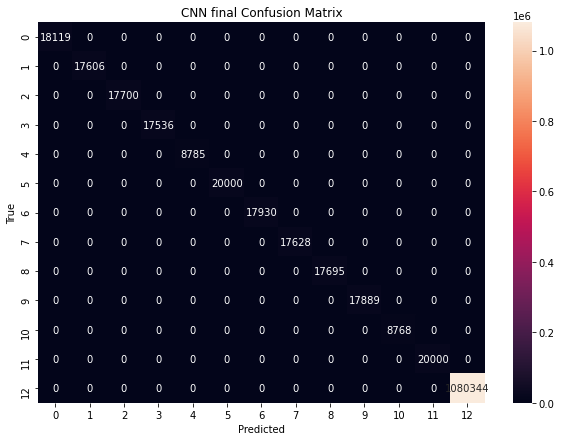

In [13]:
import seaborn as sns
def plot_confusion_mat(conf_mat, title = ""):
    plt.figure(figsize=(10,7))
    ax = sns.heatmap(conf_mat, annot=True, fmt="d")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()
    
plot_confusion_mat(conf_mat, title = "CNN final Confusion Matrix" )

## 10-fold cross validation for 3 classifiers

In [14]:
# 10-fold for CNN
# random sampling rate of the each fold in 10-fold
cnn_random_sampling_rate = 0.5

if test_CNN_ten_fold:

    train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg")

    cnn_tf = CNNClassifier()

    confusion_matrices_cnn, accuracies_cnn, accuracies_balanced_cnn, train_time_cost_cnn, validation_time_cost_cnn = \
    ConfusionMatrix(cnn_tf, train_file_names, RandomFilter, sampling_rate = cnn_random_sampling_rate)


In [15]:
if test_CNN_ten_fold:
    # dump the matrices for report.
    os.makedirs(os.path.dirname(ten_fold_result_path), exist_ok = True)

    np.save(ten_fold_result_path + "confusion_matrices_cnn.npy", confusion_matrices_cnn)
    np.save(ten_fold_result_path + "accuracies_cnn.npy", accuracies_cnn)
    np.save(ten_fold_result_path + "accuracies_balanced_cnn.npy", accuracies_balanced_cnn)
    np.save(ten_fold_result_path + "train_time_cost_cnn.npy", train_time_cost_cnn)
    np.save(ten_fold_result_path + "validation_time_cost_cnn.npy", validation_time_cost_cnn)

    cnn_tf.SaveModel(cnn_model_file)


In [16]:
# load the 10 fold results directly if needed.
if test_CNN_ten_fold:
    confusion_matrices_cnn = np.load(ten_fold_result_path + "confusion_matrices_cnn.npy")
    accuracies_cnn = np.load(ten_fold_result_path + "accuracies_cnn.npy")
    accuracies_balanced_cnn = np.load(ten_fold_result_path + "accuracies_balanced_cnn.npy")
    train_time_cost_cnn = np.load(ten_fold_result_path + "train_time_cost_cnn.npy")
    validation_time_cost_cnn = np.load(ten_fold_result_path + "validation_time_cost_cnn.npy")



### Bonus: GUI: see GUI_with_Classifiers.ipynb
    Run Bonus_GUI/GUI_with_classifiers.ipynb